# Optm  
.

In [1]:
# load libraries
import csv
import matplotlib.pyplot as plt
import multiprocessing as mp 
import numpy as np
import scipy.io as sio
import scipy.stats as stat
import zipfile
from tvb.simulator.plot.tools import *
from tvb.simulator.lab import *
from tvb.contrib.scripts.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI

LOG = get_logger('BBt')

2022-02-16 19:33:22,745 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [2]:
import pandas as pd
print(pd.__version__)

1.4.0


## Introduction  
a

## Load files 
Put Input data folder in the same directory of this python notebook.
Input data needs to follow the directory structure below:
```
TVB_bbt.ipynb
StaticOptimization.xlsx
TVB_input
│   CONXXTX (Control/Patients + number + T1/T2)
│   │   FC.mat
│   │   SCthrAn.mat
│   └───CON02T1_TVB.zip
│       │   areas.txt
│       │   average_orientations.txt
│       │   centres.txt
│       │   cortical.txt
│       │   hemisphere.txt
│       │   tract_lengths.txt.txt
│       │   weights.txt
│   
└───CONXXTX
    ```

In [3]:
# Set directory path
import os
data_dir = os.path.abspath("TVB_input")
zip_suffix = "_TVB"

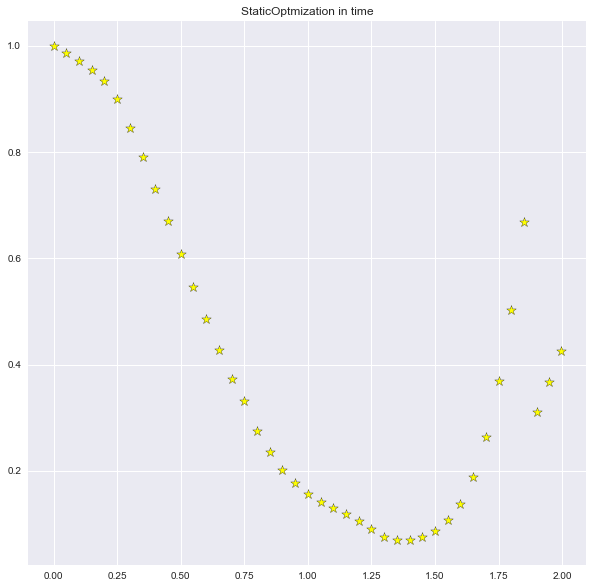

In [4]:
var = pd.read_excel('StaticOptimization.xlsx', index_col=1)
''' print(var) '''
x = list(var['X'])
y = list(var['Ynorm'])
plt.figure(figsize=(10,10))
plt.style.use('seaborn')
plt.scatter(x,y,marker="*",s=100,edgecolors="black",c="yellow")
plt.title("StaticOptmization in time")
plt.show()

In [5]:
f_sampling = 1/(x[2]-x[1])
print(f_sampling) #Hz

20.0


## Connecting
Using Static optimization in time as input of evoked responses 



In [6]:
conn = connectivity.Connectivity.from_file()
conn_coupling = coupling.Linear(a=numpy.array([0.042]))

WARNING  File 'hemispheres' not found in ZIP.


## Set up a model (arbitrary)


In [7]:
mod = models.Generic2dOscillator(a=numpy.array([-0.5]), b=numpy.array([-15.0]), c=numpy.array([0.0]), d=numpy.array([0.02]))

In [8]:
hiss    = noise.Additive(nsig = numpy.array([0.015]))
heunint = integrators.HeunStochastic(dt=2**-6, noise=hiss)

## Build a Stimulus
According to the study by Yuan et al. [1], hand, wrist and arm movement cover the position of C3 and C4 to the center of scalp. Accordingly, apart from the positions of C3, Cz and C4 that are on the area, the adjacent positions which are F3, Fz, F4, P3, Pz, P4, T7 and T8 are also chosen. [1]: https://doi.org/10.1186/s12938-018-0534-0



In TVB's connectivity demo dataset region 5 and 6 represent areas of C3 and C4. (https://github.com/the-virtual-brain/tvb-data/blob/master/tvb_data/sensors/eeg_brainstorm_65.txt)

In [9]:
conn.configure()

stim_weights = numpy.zeros((conn.number_of_regions, 1))
#stim_weights[nodes] = numpy.array([3.5, 0.0])[:, numpy.newaxis]
eqn_t = equations.PulseTrain()
eqn_t.parameters["onset"] = 500.0 # ms
eqn_t.parameters["tau"]   = 5.0   # ms
eqn_t.parameters["T"]     = 50.  # 0.02kHz repetition frequency

## (re)Defining the stimuli


In [10]:
conn = connectivity.Connectivity.from_file()
nodes = [5, 8] #C3 and P3
# configure stimulus spatial pattern
weighting = numpy.zeros((76, ))

eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 1.5e3 #ms
eqn_t.parameters['T'] = 100.0     #ms
eqn_t.parameters['tau'] = 50.0    #0.02KHz repetition freq

WARNING  File 'hemispheres' not found in ZIP.


In [11]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=conn,
    weight=weighting)

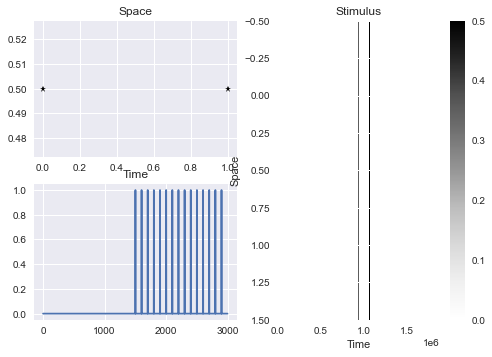

In [17]:
#Configure space and time for 1 case scenario
weighting[nodes] = 0.5

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=conn,
    weight=weighting)

stimulus.configure_space((nodes))
stimulus.configure_time(numpy.arange(0e3, 3e3, 5**-4)) #start, finish, 



#plot
plot_pattern(stimulus)

What should be seen above are three plots:
1)top-left is the spatial component of the stimuli,
indicating the strength with which the stimuli enters each node; 
2)bottom-left is the temporal profile for the stimuli; 
3)the colour plot on the right represents the combination of these
two components.

In [28]:
weights=y; #y is the Static Optimization obtained with the OpenSim
f_sampling = 1/(x[2]-x[1])

eqn_t = equations.PulseTrain()

for i in range(len(weights)-1):
    
    ds = y[i+1]-y[i]
    weighting[nodes] = y[i]
   
    
    
    eqn_t.parameters['onset'] = 1.5e3 #ms
    eqn_t.parameters['T'] = 100.0     #ms
    eqn_t.parameters['tau'] = 50.0 *ds  #0.02KHz repetition freq
    
    
    stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=conn,
    weight=weighting)
    
    stimulus.configure_space((nodes))
    stimulus.configure_time(numpy.arange(0e3, 3e3, 5**-4)) #start, finish, 
    
    
    #plot_pattern(stimulus)
    #hold plots
print(y[i])
print(ds)

#plot


0.3674656297418289
0.05907482173643136


For every value in the Static Optimization, the time configuration should be detailed (start/finish, slp of the stimulus). 

In [ ]:
import tvb.datatypes.projections as projections

conn = connectivity.Connectivity.from_file()
conn_coupling = coupling.Linear(a=numpy.array([0.042]))


mod = models.Generic2dOscillator(a=numpy.array([-0.5]), b=numpy.array([-15.0]), c=numpy.array([0.0]), d=numpy.array([0.02]))

hiss    = noise.Additive(nsig = numpy.array([0.015]))
heunint = integrators.HeunStochastic(dt=2**-6, noise=hiss)

conn.configure()
nodes = [5, 8] #C3 and P3
stim_weights = numpy.zeros((conn.number_of_regions, 1))
stim_weights[nodes] = numpy.array([3.5, 0.0])[:, numpy.newaxis]
eqn_t = equations.PulseTrain()


eqn_t.parameters["onset"] = 500.0 # ms
eqn_t.parameters["tau"]   = 5.0   # ms
eqn_t.parameters["T"]     = 500.  # 0.002kHz repetition frequency

stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = conn, 
                                  weight = stim_weights)
    
    
pr = projections.ProjectionSurfaceEEG.from_file()
ss = sensors.SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt")
rm = region_mapping.RegionMapping.from_file()

rec = (monitors.TemporalAverage(period=1e3 / 2048.), 
       monitors.EEG(projection=pr, sensors=ss, region_mapping=rm, period=1e3/2048.))

def config_sim(stim=None):
    sim = simulator.Simulator(model = mod, 
                          connectivity = conn,
                          coupling = conn_coupling, 
                          integrator = heunint, 
                          monitors = rec,
                          stimulus = stim)
                    
    sim.configure()
    return sim

def run_simulation(sim):
    #Perform the simulation
    tavg_data = []
    tavg_time = []
    eeg_data = []
    eeg_time = []
    for tavg, eeg in sim(simulation_length=2**10):
    # approx 4 sec
        if not tavg is None:
            tavg_time.append(tavg[0])
            tavg_data.append(tavg[1])
            
        if not eeg is None:
            eeg_time.append(eeg[0])
            eeg_data.append(eeg[1])
            
    return (tavg_data, tavg_time, eeg_data, eeg_time)


# Results: Activity in absence of simulation

In [ ]:
sim = config_sim()
out = run_simulation(sim) 

TAVG = numpy.array(out[0]) #tavg_data
tt   = numpy.array(out[1]) #tavg_time
EEG  = numpy.array(out[2]) #eeg_data

plt.show()

plt.subplot(2,1,1)
plt.plot(tt, TAVG[:, 0, nodes, 0])
plt.title("Temporal Averaged time-series")

plt.subplot(2,1,2)
plt.plot(tt, EEG[:, 0, 60, 0], 'k')
plt.title("EEG")

plt.tight_layout()

# Results: Stimulus-driven activity


In [ ]:
sim = config_sim(stim=stimulus)
stout = run_simulation(sim)

STAVG = numpy.array(stout[0])
stt   = numpy.array(stout[1])
SEEG  = numpy.array(stout[2])

plt.figure()

plt.subplot(2,1,1)
plt.plot(stt, STAVG[:, 0, nodes, 0])
plt.title("Stim - Temporal Averaged time-series")

plt.subplot(2,1,2)
plt.plot(stt, SEEG[:, 0, 60, 0], 'k')
plt.title("Stim - EEG")